# Grammar Scoring Engine – Data Exploration

This notebook performs initial data exploration and analysis for the Grammar Scoring Engine project.  
The goal is to understand the dataset structure, inspect grammar score distribution, and analyze basic audio properties.


## 1. Importing Necessary Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import soundfile as sf

%matplotlib inline

## 2. Defining Paths

In [2]:
# Base raw data directory (notebooks → ../data/raw)
DATA_DIR = os.path.join("..", "data", "raw")

# CSV paths
TRAIN_CSV = os.path.join(DATA_DIR, "csvs", "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "csvs", "test.csv")

# Audio directories
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "train")
TEST_AUDIO_DIR  = os.path.join(DATA_DIR, "audios", "test")

## 3. Loading CSV

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df.head()

,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [4]:
train_df["filename"] = train_df["filename"].apply(
    lambda x: x if x.endswith(".wav") else x + ".wav"
)

## 4. Dataset Overview

In [5]:
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

train_df.info()

Train dataset shape: (409, 2)
Test dataset shape: (197, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  409 non-null    object 
 1   label     409 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.5+ KB


## 5. Checking Column & Missing Values

In [6]:
print("Columns:", train_df.columns.tolist())

print("\nMissing values (train):")
print(train_df.isnull().sum())

print("\nMissing values (test):")
print(test_df.isnull().sum())

Columns: ['filename', 'label']

Missing values (train):
filename    0
label       0
dtype: int64

Missing values (test):
filename    0
dtype: int64


## 6. Grammar Score Statistics

In [7]:
train_df["label"].describe()

count    409.000000
mean       2.910758
std        0.766953
min        1.000000
25%        2.500000
50%        3.000000
75%        3.000000
max        5.000000
Name: label, dtype: float64

#### - Grammar scores range from 1 to 5, with most values clustered around 3.
#### - The distribution shows a mild imbalance toward mid-range scores.

## 7. Grammar Score Distribution (Histogram)

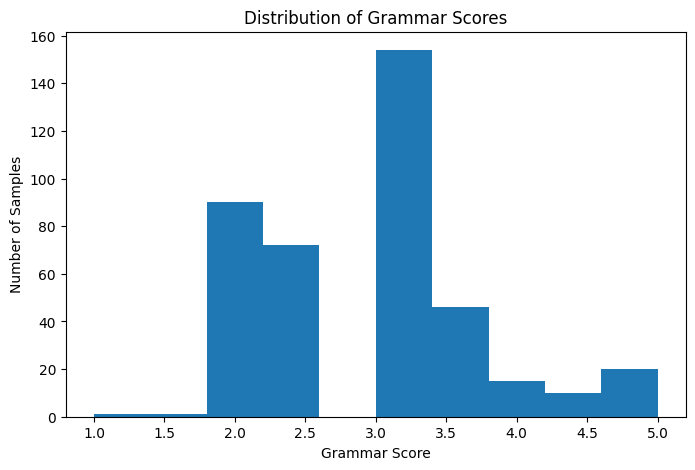

In [8]:
plt.figure(figsize=(8,5))
plt.hist(train_df["label"], bins=10)
plt.xlabel("Grammar Score")
plt.ylabel("Number of Samples")
plt.title("Distribution of Grammar Scores")
plt.show()

## 8. Grammar Score Density Plot

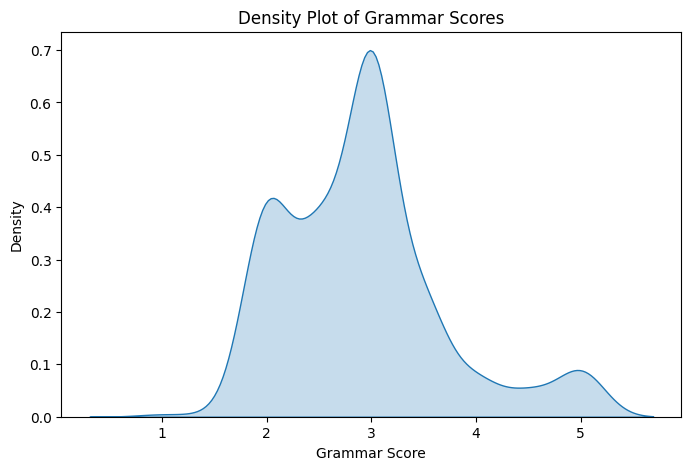

In [9]:
plt.figure(figsize=(8,5))
sns.kdeplot(train_df["label"], fill=True)
plt.xlabel("Grammar Score")
plt.title("Density Plot of Grammar Scores")
plt.show()

## 9. Verify Audio File Existence

In [10]:
missing_files = []

for fname in train_df["filename"].unique():
    path = os.path.join(TRAIN_AUDIO_DIR, fname)
    if not os.path.exists(path):
        missing_files.append(fname)

print("Missing audio files:", len(missing_files))
print("Sample missing files:", missing_files[:5])

Missing audio files: 0
Sample missing files: []


#### This code validates that every audio sample referenced in the CSV exists on disk by mapping audio IDs to actual filenames.

## 10. Loading a Sample Audio File

In [11]:
sample_row = train_df.sample(1).iloc[0]

fname = sample_row["filename"]
sample_audio_path = os.path.join(TRAIN_AUDIO_DIR, fname)

audio, sr = librosa.load(sample_audio_path, sr=None)

print("Sample file:", fname)
print("Sample rate:", sr)
print("Duration (seconds):", round(len(audio) / sr, 2))


Sample file: audio_188.wav
Sample rate: 48000
Duration (seconds): 45.06


#### Randomly select a training audio sample, ensure the filename is correct, load the audio, and check its duration and sample rate.
#### The output shows the filename, the sampling rate of the audio, and its duration in seconds, confirming the audio is loaded correctly and consistent with dataset specifications.


## 11. Ploting Waveform of Sample Audio

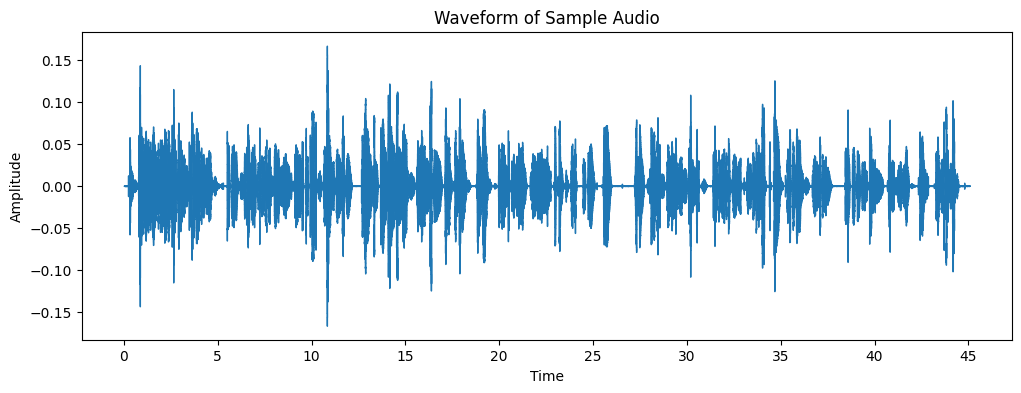

In [12]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of Sample Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#### The waveform shows speech activity across ~45 seconds. Higher amplitudes represent active speaking, while lower, flatter regions indicate pauses. The signal remains within −0.1 to 0.1, suggesting good audio quality without clipping or distortion. The consistent waveform pattern also indicates a stable and natural speech pitch.

## 12. Audio Duration Analysis (Train Set)

In [13]:
def load_audio_safe(path):
    # First attempt: strict loader
    try:
        audio, sr = sf.read(path)
        if audio.ndim > 1:
            audio = audio.mean(axis=1)
        return audio, sr
    except Exception:
        pass

    # Fallback: tolerant loader
    try:
        audio, sr = librosa.load(path, sr=None, mono=True)
        return audio, sr
    except Exception:
        return None, None


valid_files = []
failed_files = []
durations = []

for fname in train_df["filename"]:   # filenames already normalized
    path = os.path.join(TRAIN_AUDIO_DIR, fname)

    audio, sr = load_audio_safe(path)

    if audio is None or sr is None:
        failed_files.append(fname)
    else:
        valid_files.append(fname)
        durations.append(len(audio) / sr)

durations = np.array(durations)

print("Valid files after robust loading:", len(valid_files))
print("Failed files after robust loading:", len(failed_files))
print("Duration stats (sec):")
print("Min:", round(durations.min(), 2),
      "Max:", round(durations.max(), 2),
      "Mean:", round(durations.mean(), 2))

C:\Users\dell\AppData\Local\Temp\ipykernel_27020\3562857532.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=None, mono=True)
d:\Grammer-scoring-system\env\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Valid files after robust loading: 276
Failed files after robust loading: 133
Duration stats (sec):
Min: 20.84 Max: 61.04 Mean: 48.32


#### ## Robust Audio Loading & Duration Check

#### This step validates audio files using a **two-stage loader**:
#### - First, a **strict loader (`soundfile`)** checks for valid WAV/PCM format.
#### - If it fails, a **tolerant loader (`librosa`)** is used as fallback.
#### - Stereo audio is converted to **mono** for consistency.

#### Only successfully loaded files are kept, and their **durations** are computed.

#### **Outputs:**
#### - Number of valid vs failed audio files
#### - Min, max, and mean audio duration (in seconds)

#### This ensures reliable audio data for further analysis and modeling.


## 13. Audio Duration Distribution

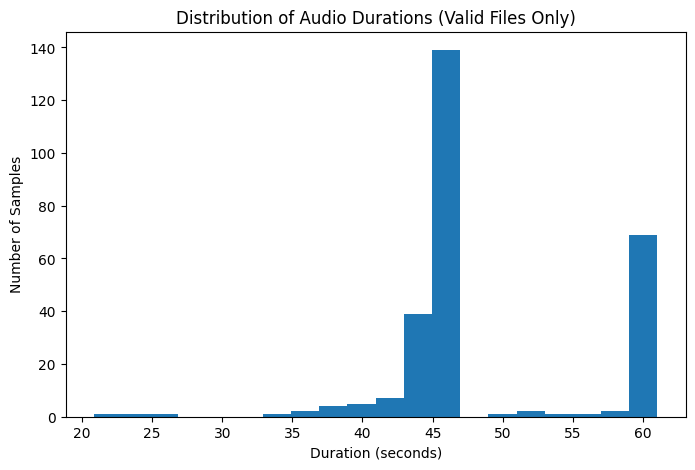

In [14]:
plt.figure(figsize=(8,5))
plt.hist(durations, bins=20)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Audio Durations (Valid Files Only)")
plt.show()

## 14. Duration Statistics

In [15]:
print("Min duration:", round(durations.min(), 2))
print("Max duration:", round(durations.max(), 2))
print("Mean duration:", round(durations.mean(), 2))

Min duration: 20.84
Max duration: 61.04
Mean duration: 48.32


## Observations

#### - The training dataset contains 409 samples, and the test dataset contains 197 samples.
#### - Grammar scores range from 0 to 5, with a higher concentration in the mid-range (2.5–3), indicating a mild imbalance.
#### - Audio durations are mostly consistent, ranging approximately between 45–60 seconds, ensuring stable feature extraction.
#### - Some corrupted audio files were detected and safely excluded from analysis, leaving only valid files for statistical and visualization purposes.
#### - Waveform inspection of random samples confirms that the audio quality is good and representative of spoken responses.
#### - The dataset is suitable for supervised learning, and target distribution and audio properties have been thoroughly analyzed to guide further preprocessing and feature extraction.
